In [1]:
import pandas as pd
from sklearn import datasets, metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn import preprocessing
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt # plt 用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import warnings
warnings.filterwarnings('ignore')

# 讀取資料

In [2]:
data_path = 'C:\\Users\\USER\\Desktop\\a\\HR predict\\'
df_train = pd.read_csv(data_path + 'train_LZdllcl.csv')
df_test = pd.read_csv(data_path + 'test_2umaH9m.csv')

In [3]:
df_train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [4]:
df_train.shape

(54808, 14)

In [5]:
df_train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


# 資料清洗

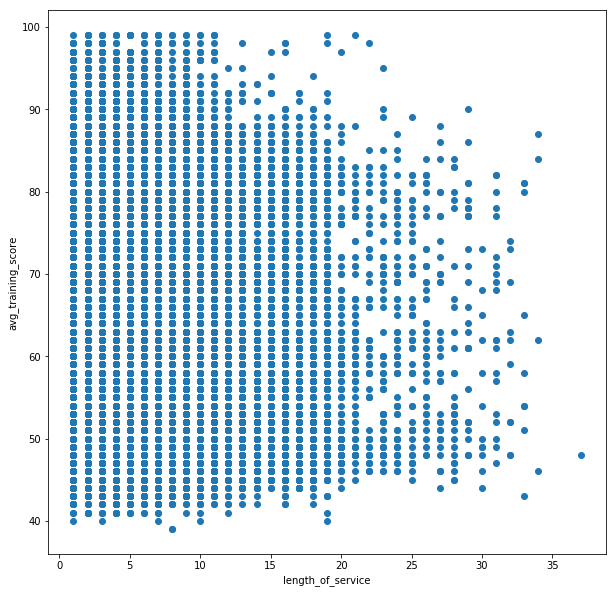

In [6]:
# Scatter plot for length_of_service & avg_training_score, 看起來右下有一個 outlier
plt.figure(figsize=(10,10)) 
plt.scatter(df_train['length_of_service'] , df_train['avg_training_score'])
plt.xlabel('length_of_service')
plt.ylabel('avg_training_score')
plt.show()

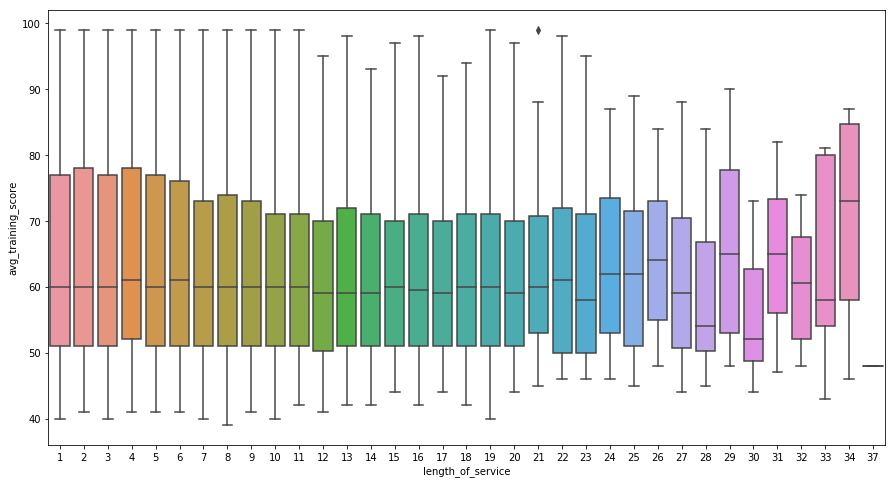

In [7]:
plt.figure(figsize=(15,8))
sns.boxplot(df_train.length_of_service, df_train.avg_training_score)

In [8]:
df_train[(df_train['length_of_service'] > 35)]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
31071,51576,Sales & Marketing,region_2,Bachelor's,m,sourcing,2,60,5.0,37,0,0,48,0


In [9]:
df_train[(df_train['length_of_service'] == 21) & (df_train['avg_training_score'] > 95 )]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
3261,66362,Procurement,region_2,Bachelor's,f,other,1,60,3.0,21,1,0,99,1


In [10]:
# 刪除 outlier (從總服務時間和平均訓練分數看出2個異常值)
df_train =  df_train[(df_train['employee_id'] != 51576) & (df_train['employee_id'] != 66362)]

In [11]:
df_train.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54806.000000,54806.000000,54806.000000,50682.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000
mean,39195.109057,1.253001,34.802996,3.329229,5.864668,0.351969,0.023173,63.386381,0.085155
std,22586.633559,0.609266,7.658797,1.259995,4.262608,0.477589,0.150453,13.370777,0.279115
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39224.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58729.750000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000,1.000000


In [12]:
# 大部分特徵的數據都算齊全
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54806 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54806 non-null int64
department              54806 non-null object
region                  54806 non-null object
education               52397 non-null object
gender                  54806 non-null object
recruitment_channel     54806 non-null object
no_of_trainings         54806 non-null int64
age                     54806 non-null int64
previous_year_rating    50682 non-null float64
length_of_service       54806 non-null int64
KPIs_met >80%           54806 non-null int64
awards_won?             54806 non-null int64
avg_training_score      54806 non-null int64
is_promoted             54806 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 6.3+ MB


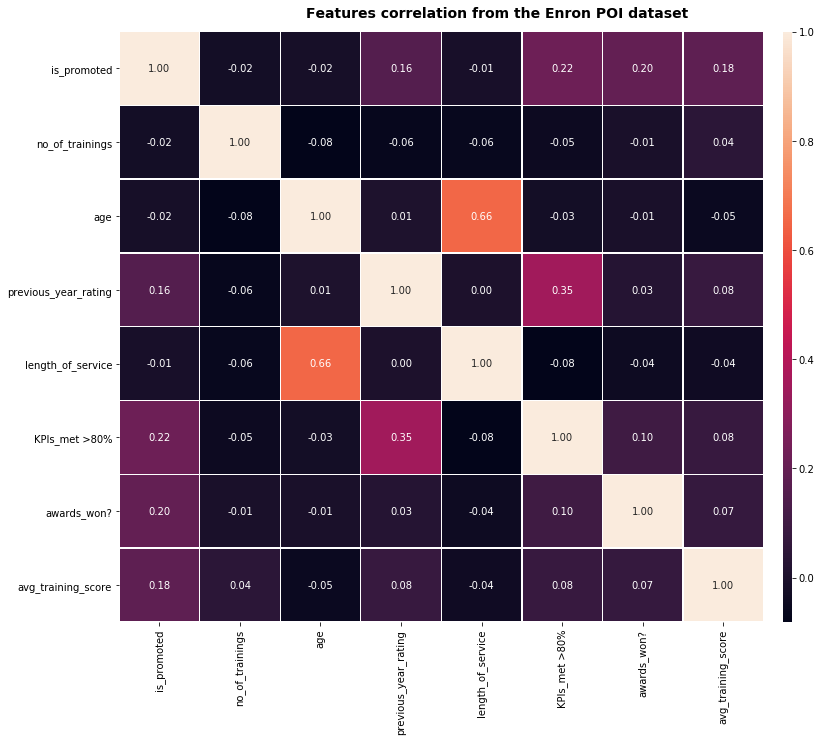

In [13]:
# 將employee_id這種身分欄位先去除

allFeatures = [ 'is_promoted','department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score']

train_data = df_train[allFeatures]
test_data = df_test[allFeatures[1:]]

correlationDataframe = train_data.corr()

# Drawing a heatmap with the numeric values in each cell
fig1, ax = plt.subplots(figsize=(14,10))
fig1.subplots_adjust(top=.945)
plt.suptitle('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"vertical", 'pad':0.025, 'aspect':70}
sns.heatmap(correlationDataframe, annot=True, fmt='.2f', linewidths=.3, ax=ax, cbar_kws=cbar_kws)

# 特徵工程

In [14]:
# 前一年的評等以中位數填補
#train_data["previous_year_rating"] = train_data["previous_year_rating"].fillna(train_data['previous_year_rating'].median())
#test_data["previous_year_rating"] = test_data["previous_year_rating"].fillna(test_data['previous_year_rating'].median())

In [15]:
# 列出 education 重複最多的數值
print(df_train['education'].value_counts().head())

Bachelor's          36667
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64


In [16]:
print(train_data['education'].value_counts().head())

Bachelor's          36667
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64


In [17]:
# 學歷NA填補 None
train_data['education'] = train_data['education'].fillna('None')
test_data['education'] = test_data['education'].fillna('None')

In [18]:
test_data['education'].mode()

0    Bachelor's
dtype: object

In [19]:
#只取類別值 (object) 型欄位, 存於 object_features 中
object_features = []
for dtype, feature in zip(train_data.dtypes, train_data.columns):
    if dtype == 'object':
        object_features.append(feature)
print(f'{len(object_features)} Object Features : {object_features}\n')

5 Object Features : ['department', 'region', 'education', 'gender', 'recruitment_channel']



In [20]:
# 我認為education是有序的,故作標籤編碼

train_data['education'] = LabelEncoder().fit_transform(train_data['education'])
test_data['education'] = LabelEncoder().fit_transform(test_data['education'])

In [21]:
# 將缺失值Nono=3改為0 = Bachelor's(眾數填補)
train_data['education'][train_data['education'] == 3] = 0

In [22]:
# gender直接標籤編碼的效果跟onehot差不多

train_data['gender'] = LabelEncoder().fit_transform(train_data['gender'])
test_data['gender'] = LabelEncoder().fit_transform(test_data['gender'])

In [23]:
# 對 region 和 age 做計數編碼(可能地區的偏僻與否跟在職年齡層有關係)
count_train = train_data.groupby(['region'])['age'].agg({'region_count':'size'}).reset_index()
count_test = test_data.groupby(['region'])['age'].agg({'region_count':'size'}).reset_index()

train_data = pd.merge(train_data, count_train, on=['region'], how='left')
test_data = pd.merge(test_data, count_test, on=['region'], how='left')

count_train.sort_values(by=['region'], ascending=False).head(10)

,region,region_count
33,region_9,420
32,region_8,655
31,region_7,4843
30,region_6,690
29,region_5,766
28,region_4,1703
27,region_34,292
26,region_33,269
25,region_32,945
24,region_31,1935


In [24]:
# 對region做特徵雜湊
train_data['region_Hash'] = train_data['region'].map(lambda x:hash(x) % 15)
test_data['region_Hash'] = test_data['region'].map(lambda x:hash(x) % 15)

In [25]:
# 所待的部門與員工訓練未如期完成可能有關係,我找尋部門間較難如期完成訓練所累積的最大次數
maxscore_train = train_data.groupby(['department'])['no_of_trainings'].max().reset_index()
maxscore_train.columns = ['department','max_no_training']
maxscore_test = test_data.groupby(['department'])['no_of_trainings'].max().reset_index()
maxscore_test.columns = ['department','max_no_training']

train_data = pd.merge(train_data, maxscore_train, on=['department'], how='left')
test_data = pd.merge(test_data, maxscore_test, on=['department'], how='left')

maxscore_train.sort_values(by=['department'], ascending=False).head(10)

,department,max_no_training
8,Technology,7
7,Sales & Marketing,10
6,R&D,5
5,Procurement,10
4,Operations,5
3,Legal,3
2,HR,3
1,Finance,5
0,Analytics,4


In [26]:
# 各部門間員工訓練未完成次數越少,前一年的評比較好
rating_no_training_train = train_data.groupby(['previous_year_rating'])['max_no_training'].mean().reset_index()
rating_no_training_train.columns = ['previous_year_rating','rating_no_training']
rating_no_training_test = test_data.groupby(['previous_year_rating'])['max_no_training'].mean().reset_index()
rating_no_training_test.columns = ['previous_year_rating','rating_no_training']

rating_no_training_train['rating_no_training'] = 1/rating_no_training_train['rating_no_training']*100
rating_no_training_test['rating_no_training'] = 1/rating_no_training_test['rating_no_training']*100

train_data = pd.merge(train_data, rating_no_training_train, on=['previous_year_rating'], how='left')
test_data = pd.merge(test_data, rating_no_training_test, on=['previous_year_rating'], how='left')


rating_no_training_train.sort_values(by=['previous_year_rating'], ascending=False).head(10)

,previous_year_rating,rating_no_training
4,5.0,14.606895
3,4.0,14.350681
2,3.0,13.888619
1,2.0,12.869719
0,1.0,12.267145


In [27]:
# 我相信所待的部門與公司給予成績可能有關係
midscore_train = train_data.groupby(['department'])['avg_training_score'].median().reset_index()
midscore_train.columns = ['department','median_score']
midscore_test = test_data.groupby(['department'])['avg_training_score'].median().reset_index()
midscore_test.columns = ['department','median_score']

train_data = pd.merge(train_data, midscore_train, on=['department'], how='left')
test_data = pd.merge(test_data, midscore_test, on=['department'], how='left')

midscore_train.sort_values(by=['department'], ascending=False).head(10)

,department,median_score
8,Technology,80
7,Sales & Marketing,50
6,R&D,85
5,Procurement,70
4,Operations,60
3,Legal,60
2,HR,50
1,Finance,60
0,Analytics,85


In [28]:
# 年齡以區間的方式分類,並做出各區間中位數年齡
train_data["age_interval"] = pd.cut(train_data["age"], [ 19, 23, 40 ,60])
test_data["age_interval"] = pd.cut(test_data["age"], [  19, 23, 40 ,60])

medianage_train = train_data.groupby(['age_interval'])['age'].median().reset_index()
medianage_train.columns = ['age_interval','median_age']
medianage_test = test_data.groupby(['age_interval'])['age'].median().reset_index()
medianage_test.columns = ['age_interval','median_age']

train_data = pd.merge(train_data, medianage_train, on=['age_interval'], how='left')
test_data = pd.merge(test_data, medianage_test, on=['age_interval'], how='left')

medianage_train.sort_values(by=['age_interval'], ascending=False).head(10)

,age_interval,median_age
2,"(40, 60]",46
1,"(23, 40]",32
0,"(19, 23]",22


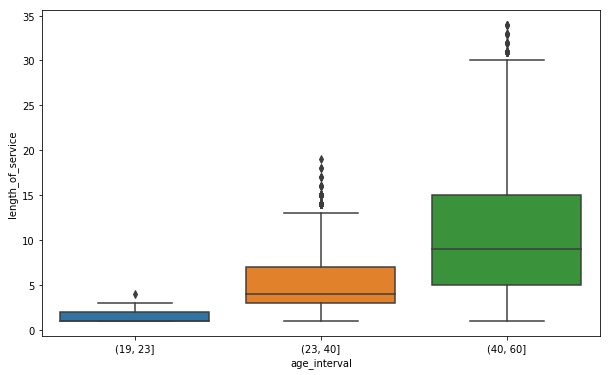

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(train_data['age_interval'] , train_data['length_of_service'])

In [30]:
#train_data['service_age_diff'] = (train_data['length_of_service'] / train_data['age']) * 10

#test_data['service_age_diff'] = (test_data['length_of_service'] / test_data['age']) * 10

In [31]:
#sns.distplot(train_data['service_age_diff'])

In [32]:
# 由上圖看出該重要特徵有偏態,故取log去偏態
#train_data['service_age_diff'] = np.log1p(train_data['service_age_diff'])
#test_data['service_age_diff'] = np.log1p(test_data['service_age_diff'])

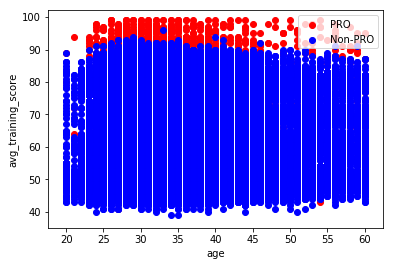

In [33]:
is_promote = (True, False)
colors = ('r', "b")
groups = ("PRO", "Non-PRO")
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for is_promote, color, group in zip(is_promote, colors, groups):
    data_plot = train_data[train_data['is_promoted'] == is_promote]
    ax.scatter(data_plot['age'], data_plot['avg_training_score'], c=color, label=group)
plt.xlabel("age")
plt.ylabel("avg_training_score")
plt.legend(loc=1)
plt.show()

In [34]:
# 升遷的人多集中在年紀較輕且分數高

train_data['score_age_diff'] = (train_data['avg_training_score'] - train_data['age']) * 10

test_data['score_age_diff'] = (test_data['avg_training_score'] - test_data['age']) * 10

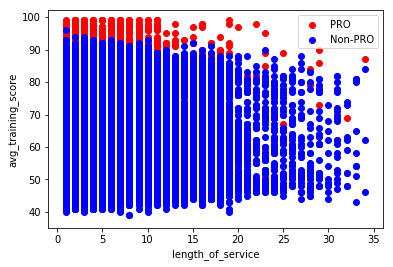

In [35]:
is_promote = (True, False)
colors = ('r', "b")
groups = ("PRO", "Non-PRO")
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for is_promote, color, group in zip(is_promote, colors, groups):
    data_plot = train_data[train_data['is_promoted'] == is_promote]
    ax.scatter(data_plot['length_of_service'], data_plot['avg_training_score'], c=color, label=group)
plt.xlabel("length_of_service")
plt.ylabel("avg_training_score")
plt.legend(loc=1)
plt.show()

In [36]:
# 由上圖看到服務時間較短且平均分數高的比較有機會升遷
# 故對此2個特徵做特徵工程

train_data['score_service_diff'] = train_data['avg_training_score'] / train_data['length_of_service'] * 10

test_data['score_service_diff'] = test_data['avg_training_score'] / test_data['length_of_service'] * 10

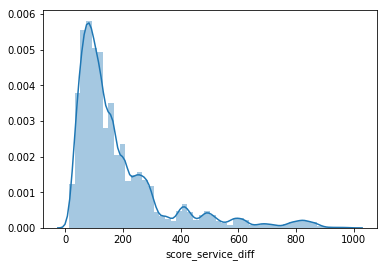

In [37]:
sns.distplot(train_data['score_service_diff'])

In [38]:
# 由上圖看出該重要特徵有偏態,故取log去偏態
train_data['score_service_diff'] = np.log1p(train_data['score_service_diff'])
test_data['score_service_diff'] = np.log1p(test_data['score_service_diff'])

In [39]:
mix_train = train_data.groupby(['region'])['score_service_diff'].min().reset_index()
mix_train.columns = ['region','mix']
mix_test = test_data.groupby(['region'])['score_service_diff'].min().reset_index()
mix_test.columns = ['region','mix']

train_data = pd.merge(train_data, mix_train, on=['region'], how='left')
test_data = pd.merge(test_data, mix_test, on=['region'], how='left')

mix_train.sort_values(by=['region'], ascending=False).head(10)

,region,mix
33,region_9,3.768330
32,region_8,3.395298
31,region_7,2.793208
30,region_6,3.277145
29,region_5,3.326549
28,region_4,3.007205
27,region_34,3.891820
26,region_33,3.385018
25,region_32,3.367296
24,region_31,3.179864


In [40]:
mix2_train = train_data.groupby(['education'])['region_count'].median().reset_index()
mix2_train.columns = ['education','mix2']
mix2_test = test_data.groupby(['education'])['avg_training_score'].median().reset_index()
mix2_test.columns = ['education','mix2']

train_data = pd.merge(train_data, mix2_train, on=['education'], how='left')
test_data = pd.merge(test_data, mix2_test, on=['education'], how='left')

mix2_train.sort_values(by=['education'], ascending=False).head(10)

,education,mix2
2,2,2808
1,1,12341
0,0,2648


In [41]:
#train_data['mix'] = train_data['region_count'] * train_data['score_service_diff']
#test_data['mix'] = test_data['region_count'] * test_data['score_service_diff']
#train_data['mix'] = np.log1p(train_data['mix'])
#test_data['mix'] = np.log1p(test_data['mix'])

In [42]:
#train_data['mix2'] = train_data['score_service_diff'] * train_data['age']
#test_data['mix2'] = test_data['score_service_diff'] * test_data['age']
#train_data['mix2'] = np.log1p(train_data['mix2'])
#test_data['mix2'] = np.log1p(test_data['mix2'])

In [43]:
# 服務時間較短且平均分數高的比較有機會升遷的一個分數,再招募管道不同下,被推薦進來是較高的
#recruscore_train = train_data.groupby(['recruitment_channel'])['score_service_diff'].median().reset_index()
#recruscore_train.columns = ['recruitment_channel','recruitment_score_service']
#recruscore_test = test_data.groupby(['recruitment_channel'])['score_service_diff'].median().reset_index()
#recruscore_test.columns = ['recruitment_channel','recruitment_score_service']

#train_data = pd.merge(train_data, recruscore_train, on=['recruitment_channel'], how='left')
#test_data = pd.merge(test_data, recruscore_test, on=['recruitment_channel'], how='left')

#recruscore_train.sort_values(by=['recruitment_channel'], ascending=False).head(10)

# 分出訓練集和測試集

In [86]:
y = train_data['is_promoted']

In [45]:
train_data.columns

Index(['is_promoted', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'region_count', 'region_Hash', 'max_no_training',
       'rating_no_training', 'median_score', 'age_interval', 'median_age',
       'score_age_diff', 'score_service_diff', 'mix', 'mix2'],
      dtype='object')

In [46]:
Features = [   'gender',
        'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'region_count', 'max_no_training', 'median_score',
        'median_age', 'score_age_diff',
       'rating_no_training', 'score_service_diff','mix2']
       #,'education','recruitment_score_service','mix','mix2','service_age_diff']
X = train_data[Features]
test = test_data[Features]

In [47]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.1, random_state=1)

# 訓練模型並預測

In [735]:
# 建立模型
clfxgb = xgb.XGBClassifier()

In [736]:
n_estimators = [300, 350 , 500, 700]
max_depth = [3,  4 ,  5,  6]
scale_pos_weight = [0.5, 0.6, 0.8 ,1 ]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, scale_pos_weight=scale_pos_weight)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(clfxgb, param_grid, n_jobs=-1, verbose=1 )

# 開始搜尋最佳參數
grid_result = grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 25.1min finished


In [737]:
grid_result.best_params_

{'max_depth': 4, 'n_estimators': 350, 'scale_pos_weight': 0.5}

In [747]:
# 使用最佳參數重新建立模型
xgb_bestparam = xgb.XGBClassifier(max_depth= 5,
                                  n_estimators= 2500 ,
                                  eta = 0.1,
                                  scale_pos_weight= 0.55,
                                 learning_rate=0.15)

In [748]:
# 訓練模型
xgb_bestparam.fit(train_X, train_y)
# 預測驗證集
val_pred = xgb_bestparam.predict(val_X)
print(metrics.accuracy_score(val_y, val_pred))

0.9377850757161103


In [749]:
#xgb_bestparam.fit(X, y)

In [750]:
y_pred = xgb_bestparam.predict(test)

In [751]:
data = {'employee_id': df_test['employee_id']}
submit = pd.DataFrame(data)
submit['is_promoted'] = y_pred

submit.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [752]:
submit.to_csv('is_pormoted_XGB.csv', index = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text yticklabel objects>)

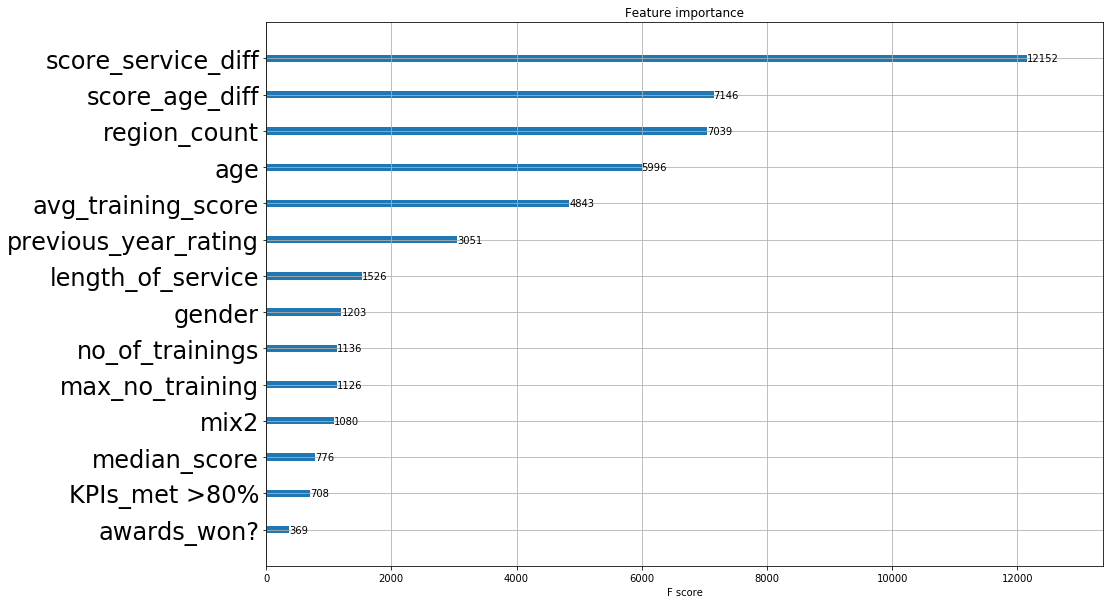

In [753]:
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(xgb_bestparam, ax=ax, ylabel=None)
plt.yticks(size=24)

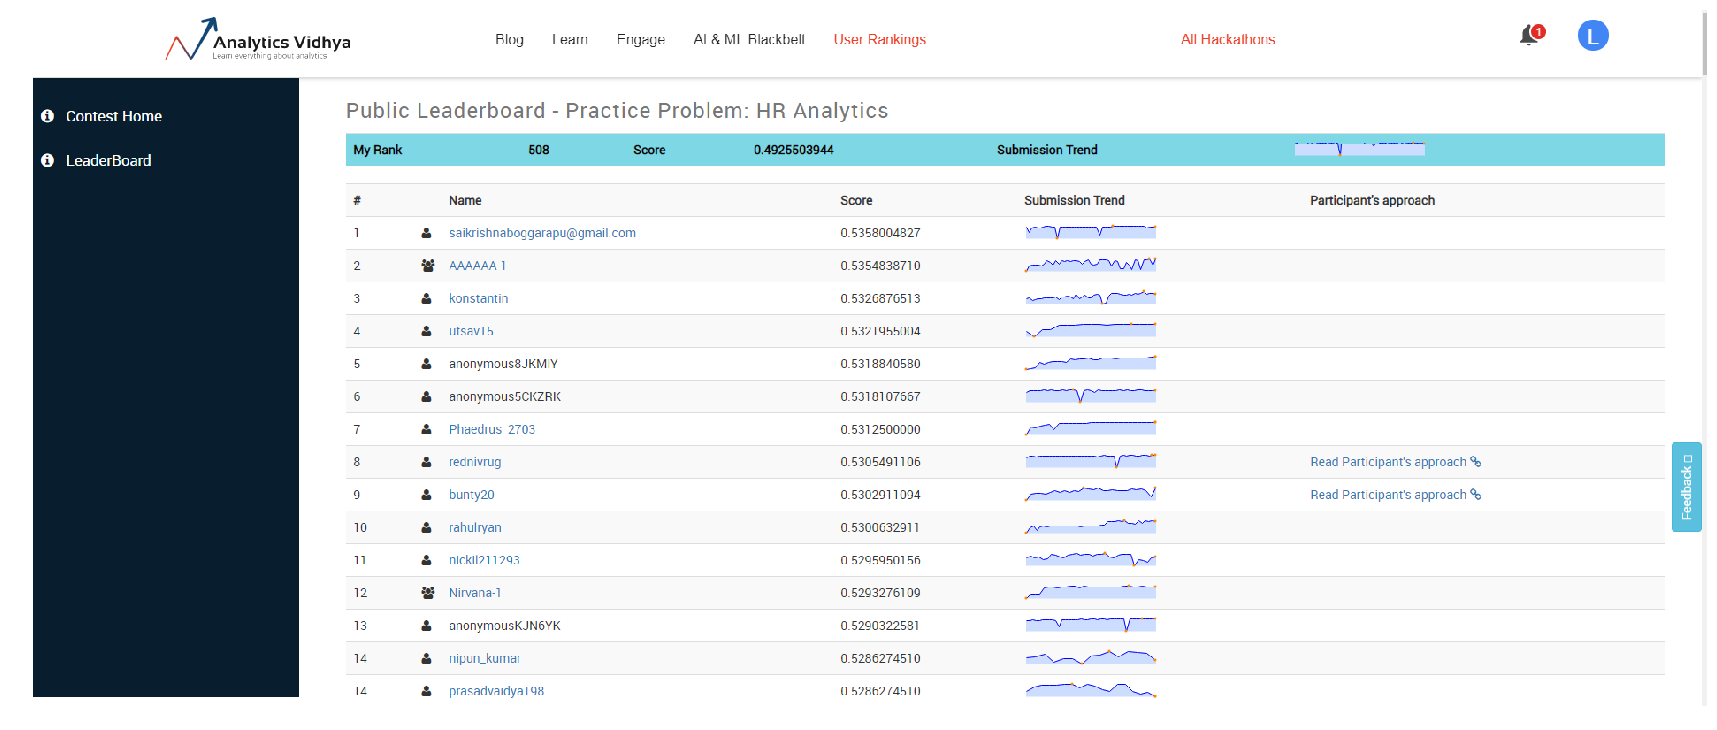

In [745]:
# 附上我的rank
plt.figure(figsize=(30,30)) 
xgbpred = mpimg.imread('rank.png')
plt.imshow(xgbpred)
plt.axis('off') # 不顯示座標軸
plt.show()